In [1]:
import os
os.listdir()

['.ipynb_checkpoints', '__notebook_source__.ipynb']

In [22]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.set_printoptions(threshold=np.inf)
rcParams['figure.figsize'] = (15,15)

In [3]:
df = pd.read_json("../input/train.json", orient='records')

In [4]:
# printing head of dataframe
df.head(10)

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."
5,jamaican,6602,"[plain flour, sugar, butter, eggs, fresh ginge..."
6,spanish,42779,"[olive oil, salt, medium shrimp, pepper, garli..."
7,italian,3735,"[sugar, pistachio nuts, white almond bark, flo..."
8,mexican,16903,"[olive oil, purple onion, fresh pineapple, por..."
9,italian,12734,"[chopped tomatoes, fresh basil, garlic, extra-..."


In [5]:
print("number of records {0}".format(len(df.id)))

number of records 39774


In [6]:
# printing cuisine types and counts
print(df.cuisine.value_counts(normalize=True))
print("Number of cuisine types {0}".format(len(df.cuisine.value_counts())))
print("number of unique ingredients {0}".format(len(set([ingredient for ingredient_list in df.ingredients.values for ingredient in ingredient_list]))))

italian         0.197063
mexican         0.161865
southern_us     0.108614
indian          0.075502
chinese         0.067205
french          0.066526
cajun_creole    0.038870
thai            0.038694
japanese        0.035777
greek           0.029542
spanish         0.024865
korean          0.020868
vietnamese      0.020742
moroccan        0.020642
british         0.020214
filipino        0.018982
irish           0.016770
jamaican        0.013225
russian         0.012294
brazilian       0.011741
Name: cuisine, dtype: float64
Number of cuisine types 20
number of unique ingredients 6714


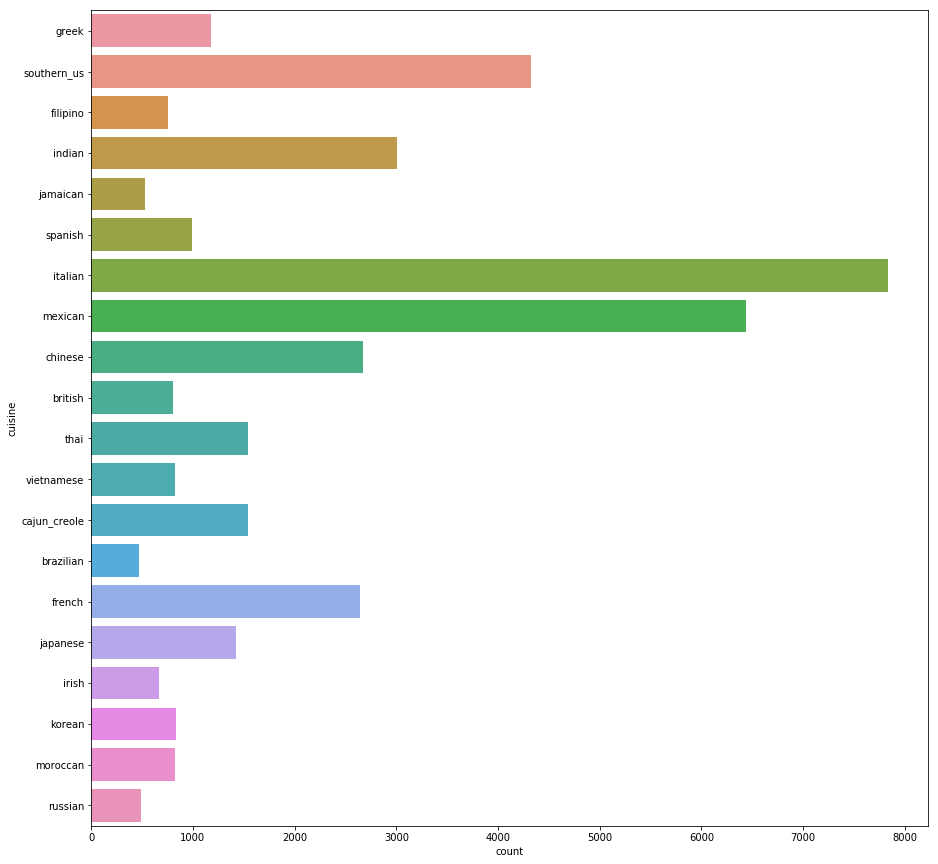

In [7]:
# plotting countplot
sns.countplot(y='cuisine',data=df)
plt.show()

In [8]:
def text_prepare(ingredient):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    DOUBLE_SPACE_RE = re.compile('\s{2,}')
    STOPWORDS = set(stopwords.words('english'))
    
    ingredient = ingredient.strip(" ")
    #lower casing letters
    ingredient = ingredient.lower()
    #replacing symbols by space
    ingredient = re.sub(REPLACE_BY_SPACE_RE,' ',ingredient)
    #deleting bad words
    ingredient = re.sub(BAD_SYMBOLS_RE,'',ingredient)
    #removing double space
    ingredient = re.sub(DOUBLE_SPACE_RE,'',ingredient)
    # remove numbers with percentages
    ingredient = re.sub('[0-9]*% ','',ingredient)
    # remove ounce information
    ingredient = re.sub("\(.*oz.\)",'',ingredient)
    # remove brand names with registered
    ingredient = re.sub("[A-Z]*[a-z]*®",'',ingredient)
    # remove brand names with trademark
    ingredient = re.sub("[A-Z]*[a-z]*™", '', ingredient)
    # remove numbers with +
    ingredient = re.sub("[0-9]+",'',ingredient)
    # replace & and -
    ingredient = ingredient.replace("&",'')
    ingredient = ingredient.replace("-", '')
    # lowercase all indegredients
    ingredient = ingredient.lower()
    # removing whitespacing once more
    ingredient = ingredient.strip()
    #removing stop words
    ingredient = ' '.join([word for word in ingredient.split(" ") if word not in STOPWORDS])
    
    return ingredient
def apply_text_prepare_to_list(ingredient_list):
    return ' '.join([text_prepare(ingredient) for ingredient in ingredient_list])

In [9]:
df.ingredients = df.ingredients.apply(apply_text_prepare_to_list)

In [11]:
print(df.head())

       cuisine     id                                        ingredients
0        greek  10259  romaine lettuce black olives grape tomatoes ga...
1  southern_us  25693  plain flour ground pepper salt tomatoes ground...
2     filipino  20130  eggs pepper salt mayonaise cooking oil green c...
3       indian  22213                     water vegetable oil wheat salt
4       indian  13162  black pepper shallots cornflour cayenne pepper...


So two approaches now
* Bi gram model
* TfIdf model

And lastly
* 1d Conv Model

We will use the former two combined with
* Logistic Regressor
* Multi Layer Perceptron (Classic Neural Network)

In [12]:
DICT_SIZE = 10000
def tfidf():
    tfidf_vectorizer = TfidfVectorizer(token_pattern=r'(\S+)',ngram_range=(1,2),strip_accents='unicode',max_features=DICT_SIZE)
    return tfidf_vectorizer
    
def vectorize(X_train,X_val,X_test,vectorizer):
    print("About to vectorize lmao",X_train.shape,X_val.shape,X_test.shape)
    X_train = vectorizer.fit_transform(X_train)
    X_val = vectorizer.transform(X_val)
    X_test = vectorizer.transform(X_test)
    return X_train.toarray(),X_val.toarray(),X_test.toarray(),vectorizer.vocabulary_

def bigram():
    bigram_vectorizer = CountVectorizer(ngram_range=(1,2),strip_accents='unicode',max_features=DICT_SIZE)
    return bigram_vectorizer

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df.ingredients.values,df.cuisine.values,train_size=0.8,test_size=0.2,random_state=2019)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,train_size=0.8,test_size=0.2,random_state=42)
print(X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape)
print(X_train[0],"\n",y_train[0])

(25455,) (6364,) (7955,) (25455,) (6364,) (7955,)
sugar halfhalf ground allspice unsalted butter vanilla extract graham crackers sweet potatoes fresh lemon juice ground ginger large eggs salt 
 southern_us


In [18]:
X_train_bow,X_val_bow,X_test_bow,bow_vocab = vectorize(X_train,X_val,X_test,bigram())
X_train_tfidf,X_val_tfidf,X_test_tfidf,tfidf_vocab = vectorize(X_train,X_val,X_test,tfidf())

About to vectorize lmao (25455,) (6364,) (7955,)
About to vectorize lmao (25455,) (6364,) (7955,)


In [19]:
print(X_train_bow.shape,X_val_bow.shape,X_test_bow.shape,X_train_tfidf.shape,X_val_tfidf.shape,X_test_tfidf.shape)
print(X_train_tfidf[0][0:10],"\n",X_train_bow[0][0:10])

(25455, 10000) (6364, 10000) (7955, 10000) (25455, 10000) (6364, 10000) (7955, 10000)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
 [0 0 0 0 0 0 0 0 0 0]


In [27]:
def logistic_classifier():
    log_clf = LogisticRegression(random_state=2019,max_iter=100,solver='liblinear')
    return log_clf

def mlp_classifier():
    mlp_clf = MLPClassifier(hidden_layer_sizes=(8,16,8),batch_size=16,random_state=2019)
    return mlp_clf

def train(X,y,clf):
    print("fitting X y with shapes {0} and {1}".format(X.shape,y.shape))
    clf.fit(X,y)
    print(clf.score(X,y))
    return clf

def predict(X,clf):
    print("predicting X y with shapes {0}".format(X.shape))
    return clf.predict(X)

def evaluate(y_val,predicted):
    # accuracy
    # f1 score
    # confusion matrix
    # precision score
    # recall score
    print("accuracy:- {0}".format(accuracy_score(y_val,predicted)))
    prec_val = precision_score(y_val,predicted,average='macro')
    rec_val = recall_score(y_val,predicted,average='macro')
    f1_val = f1_score(y_val,predicted,average='macro')
    print("precision score :- {0} \n recall score :- {1} \n f1_score:- {2}".format(prec_val,rec_val,f1_val))
    conf_mat = confusion_matrix(y_val,predicted)
    sns.heatmap(conf_mat)
    plt.show()
    
    
def pipeline(X_train,y_train,X_val,y_val,X_test,y_test,clf):
    print("Begin Training")
    train(X_train,y_train,clf)
    print("Finished Training")
    print("Begin Prediction on validation set")
    y_val_pred = predict(X_val,clf)
    print("Begin evaluation on validation set")
    evaluate(y_val,y_val_pred)
    print("Begin prediction on test set")
    y_test_pred = predict(X_test,clf)
    print("Begin evaluation on test set")
    evaluate(y_test,y_test_pred)
    

4 way approach 
1. Bag of words approach with 
    1. Logistic Regressor
    2. MLP Classifier
2. TF-IDF approach with
    1. Logistic Regressor
    2. MLP Classifier

Begin Training
fitting X y with shapes (25455, 10000) and (25455,)


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.9588293066195247
Finished Training
Begin Prediction on validation set
predicting X y with shapes (6364, 10000)
Begin evaluation on validation set
accuracy:- 0.7842551854179761
precision score :- 0.7442619725383051 
 recall score :- 0.6795359484877153 
 f1_score:- 0.7069169443429208


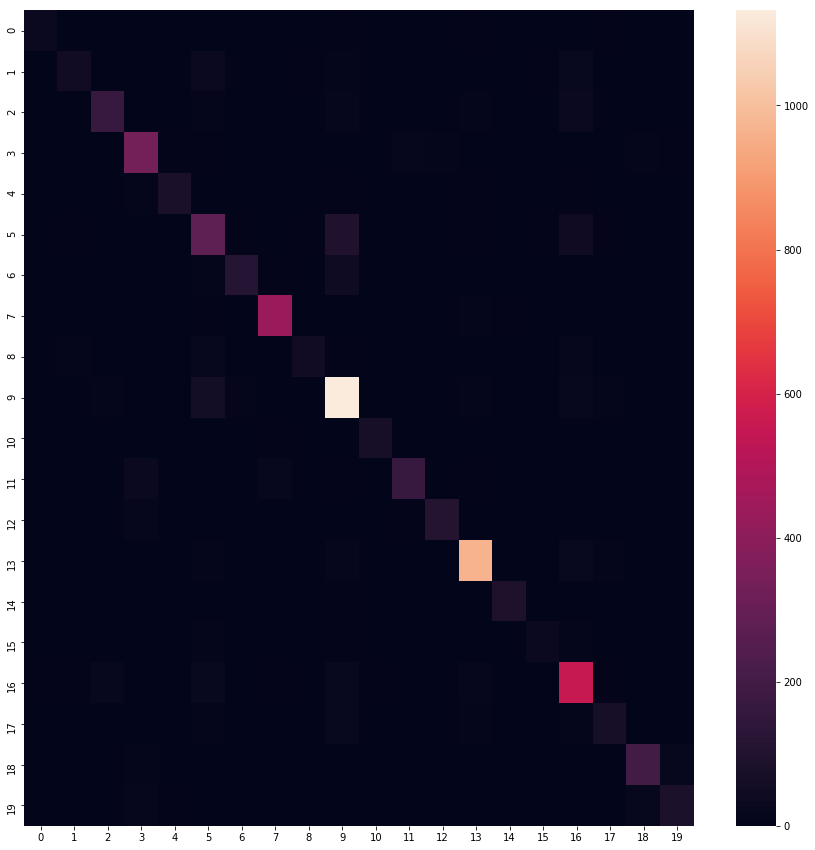

Begin prediction on test set
predicting X y with shapes (7955, 10000)
Begin evaluation on test set
accuracy:- 0.7763670647391577
precision score :- 0.7352329594222884 
 recall score :- 0.6693674734279387 
 f1_score:- 0.6971951004452073


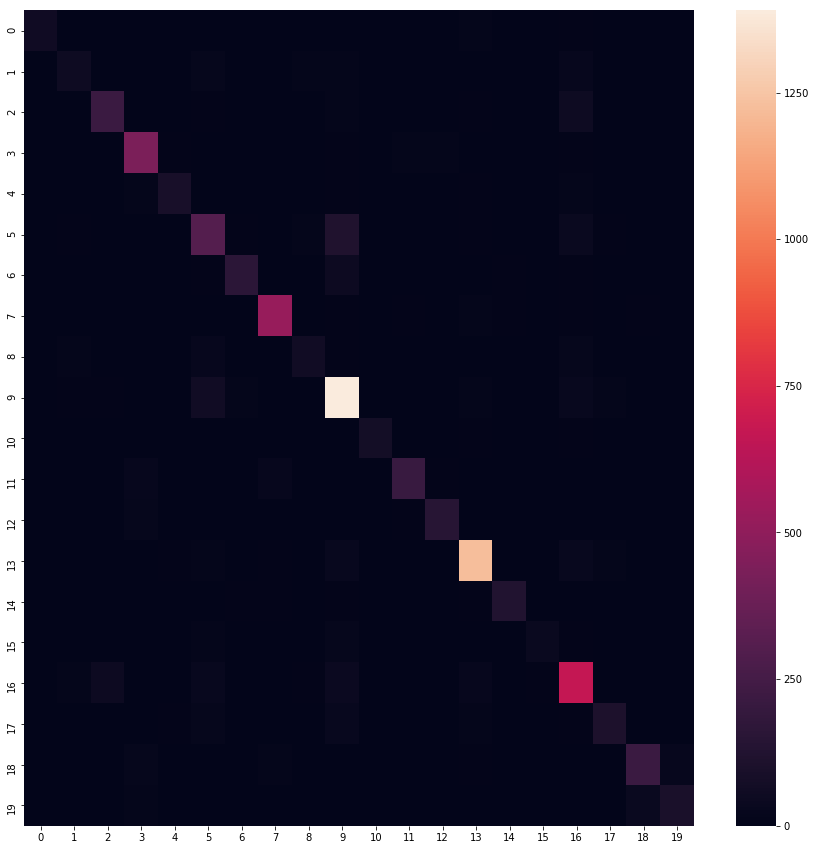

In [25]:
pipeline(X_train_bow,y_train,X_val_bow,y_val,X_test_bow,y_test,logistic_classifier())

In [28]:
pipeline(X_train_bow,y_train,X_val_bow,y_val,X_test_bow,y_test,mlp_classifier())

Begin Training
fitting X y with shapes (25455, 10000) and (25455,)


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


KeyboardInterrupt: 

In [ ]:
pipeline(X_train_tfidf,y_train,X_val_tfidf,y_val,X_test_tfidf,y_test,logistic_classifier())

In [ ]:
pipeline(X_train_tfidf,y_train,X_val_tfidf,y_val,X_test_tfidf,y_test,mlp_classifier())